In [3]:
# 1. Imports & Load Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

# Load CSV
df = pd.read_csv(r"C:\Users\LENOVO\Desktop\NeerDrishti\data\mahanadi_flood_data_2001_2024.csv", parse_dates=["Date"])

In [4]:
# 2. Label Encoding + Temporal Feature Engineering
label_encoders = {}
for col in ["District", "Landcover", "Soil Type"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df["Rain_7day_sum"] = df.groupby("District")["Rainfall (mm)"].transform(lambda x: x.rolling(7).sum()).fillna(0)
df["Water_vs_Elevation"] = df["Water Level (m)"] / (df["Elevation (m)"] + 1)

def classify_risk(row):
    if row["Rain_7day_sum"] > 150 and row["Water_vs_Elevation"] > 0.6:
        return 1  # Flood
    else:
        return 0  # No Flood


df["Flood_Risk"] = df.apply(classify_risk, axis=1)

In [5]:
# 3. Feature Set and Sequence Preparation
features = ['District', 'Latitude', 'Longitude', 'Rainfall (mm)', 'Temperature (°C)', 
            'Humidity (%)', 'River Discharge (m³/s)', 'Water Level (m)',
            'Rain_7day_sum', 'Water_vs_Elevation']
df.dropna(subset=features + ["Flood_Risk"], inplace=True)

X_all = df[features].values
Y_all = df["Flood_Risk"].values.astype(np.int32)

def create_sequences(data, labels, time_steps=30):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        Y.append(labels[i + time_steps])
    return np.array(X), np.array(Y)

X_seq, Y_seq = create_sequences(X_all, Y_all, time_steps=30)
Y_seq_cat = to_categorical(Y_seq, num_classes=2)

In [7]:
# 4. Split and Scale
X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq_cat, test_size=0.2, random_state=42)

n_samples, time_steps, n_features = X_train.shape
scaler = StandardScaler().fit(X_train.reshape(-1, n_features))
X_train = scaler.transform(X_train.reshape(-1, n_features)).reshape(n_samples, time_steps, n_features)
X_test = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape[0], time_steps, n_features)

# Display dataset shape
print(df.shape)
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

(87660, 19)
Training Samples: 70104
Testing Samples: 17526


In [7]:
# 5. Build Bi-LSTM Model
def build_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model((X_train.shape[1], X_train.shape[2]))

In [8]:
# 6. Train the Model
epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
1753/1753 [==============================] - 121s 61ms/step - loss: 0.2411 - accuracy: 0.8808 - val_loss: 0.2292 - val_accuracy: 0.8850
Epoch 2/100
1753/1753 [==============================] - 98s 56ms/step - loss: 0.2303 - accuracy: 0.8857 - val_loss: 0.2290 - val_accuracy: 0.8850
Epoch 3/100
1753/1753 [==============================] - 100s 57ms/step - loss: 0.2299 - accuracy: 0.8858 - val_loss: 0.2293 - val_accuracy: 0.8840
Epoch 4/100
1753/1753 [==============================] - 103s 59ms/step - loss: 0.2294 - accuracy: 0.8860 - val_loss: 0.2293 - val_accuracy: 0.8849
Epoch 5/100
1753/1753 [==============================] - 103s 59ms/step - loss: 0.2288 - accuracy: 0.8862 - val_loss: 0.2321 - val_accuracy: 0.8842
Epoch 6/100
1753/1753 [==============================] - 104s 60ms/step - loss: 0.2285 - accuracy: 0.8860 - val_loss: 0.2309 - val_accuracy: 0.8846
Epoch 7/100
1753/1753 [==============================] - 103s 59ms/step - loss: 0.2279 - accuracy: 0.8863 - val_l

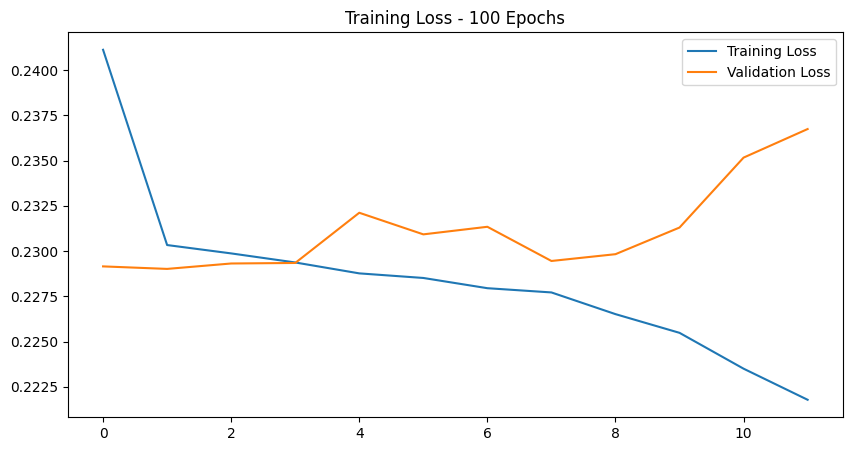

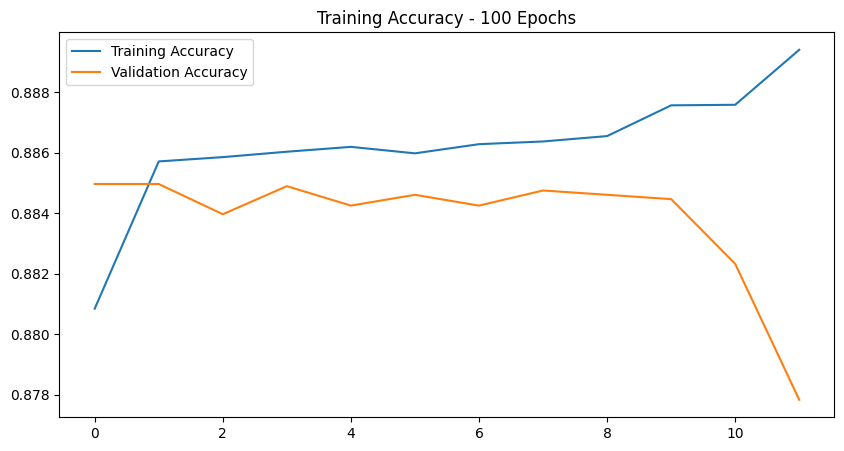

In [9]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title(f"Training Loss - {epochs} Epochs")
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title(f"Training Accuracy - {epochs} Epochs")
plt.show()

548/548 [==============================] - 11s 20ms/step - loss: 0.2325 - accuracy: 0.8819
Test Accuracy: 88.19%
548/548 [==============================] - 14s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     14069
           1       0.70      0.71      0.70      3457

    accuracy                           0.88     17526
   macro avg       0.81      0.82      0.81     17526
weighted avg       0.88      0.88      0.88     17526



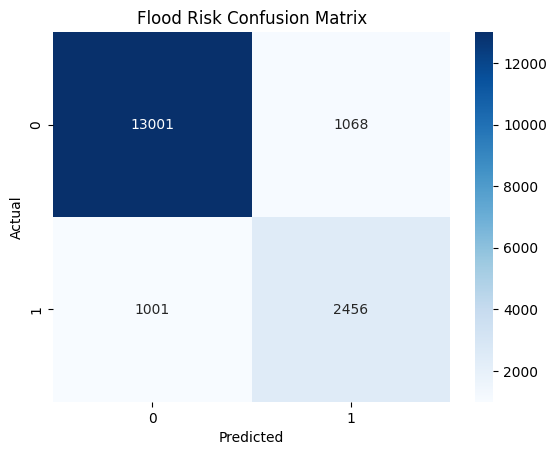

In [10]:
# 7. Evaluate and Interpret
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc:.2%}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Flood Risk Confusion Matrix")
plt.show()

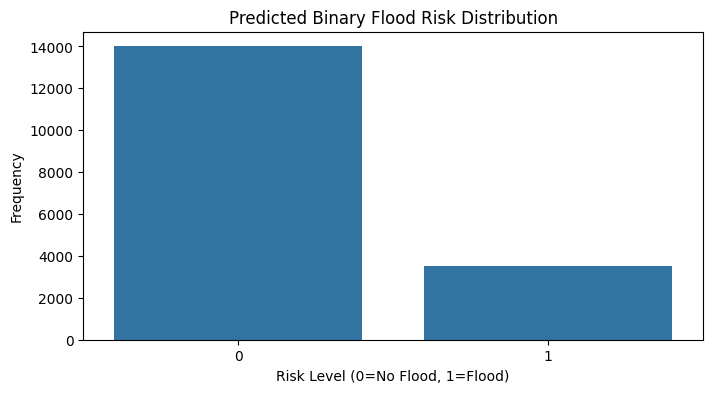

In [11]:
# 8. Risk Distribution
plt.figure(figsize=(8,4))
sns.countplot(x=y_pred_classes)
plt.title("Predicted Binary Flood Risk Distribution")
plt.xlabel("Risk Level (0=No Flood, 1=Flood)")
plt.ylabel("Frequency")
plt.show()

In [12]:
# 9. Save Model and Artifacts
model.save("mahanadi_bilstm_model.h5")
import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']